In [1]:
import os
import sys
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import argparse
import numpy as np
from typing import Optional, Dict, Any

# Set the style for plots
sns.set(style="darkgrid")

# Constants
BASE_URL = "https://api.openweathermap.org/data/2.5/forecast"
UNITS = "metric"  # Celsius
API_KEY = "83009b241480d444db00b745f38f3f7e"  # Your provided API key

In [2]:
def fetch_weather_data(city: str, api_key: str = API_KEY, units: str = "metric") -> Optional[Dict[str, Any]]:
    
    params = {
        "q": city,
        "appid": api_key,
        "units": units
    }
    try:
        response = requests.get(BASE_URL, params=params, timeout=10)
        response.raise_for_status()
        print(f"Data fetched successfully for {city}")
        return response.json()
    except requests.exceptions.HTTPError as errh:
        if response.status_code == 401:
            print("Error: Invalid API key. Please check your OpenWeatherMap API key.")
        elif response.status_code == 404:
            print(f"Error: City '{city}' not found. Please check the city name.")
        else:
            print(f"HTTP Error: {errh}")
        return None
    except requests.exceptions.ConnectionError as errc:
        print(f"Error Connecting: {errc}")
        return None
    except requests.exceptions.Timeout as errt:
        print(f"Timeout Error: {errt}")
        return None
    except requests.exceptions.RequestException as err:
        print(f"Request Exception: {err}")
        return None

In [3]:
def process_data(data: Dict[str, Any]) -> Optional[pd.DataFrame]:
    
    if data is None:
        print("Error: No data to process")
        return None
        
    try:
        records = []
        for entry in data['list']:
            dt = datetime.fromtimestamp(entry['dt'])
            temp = entry['main']['temp']
            temp_min = entry['main']['temp_min']
            temp_max = entry['main']['temp_max']
            humidity = entry['main']['humidity']
            wind_speed = entry['wind']['speed']
            weather_desc = entry['weather'][0]['description']
            weather_icon = entry['weather'][0]['icon']
            pressure = entry['main']['pressure']
            clouds = entry['clouds']['all']
            
            records.append({
                "datetime": dt,
                "temperature": temp,
                "temp_min": temp_min,
                "temp_max": temp_max,
                "humidity": humidity,
                "wind_speed": wind_speed,
                "weather": weather_desc,
                "weather_icon": weather_icon,
                "pressure": pressure,
                "cloud_coverage": clouds
            })
        
        df = pd.DataFrame(records)
        return df
    except KeyError as e:
        print(f"Error processing data: Missing key {e}")
        print(f"Available keys in data: {list(data.keys()) if data else 'No data'}")
        return None

In [4]:
def plot_weather_data(df: pd.DataFrame, city: str, output_dir: str = "."):
    
    # Create figure with subplots
    fig = plt.figure(figsize=(16, 20))
    gs = fig.add_gridspec(5, 2)
    
    # Temperature plot
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(df['datetime'], df['temperature'], marker='o', color='tomato', label='Avg Temp', linewidth=2)
    ax1.fill_between(df['datetime'], df['temp_min'], df['temp_max'], color='tomato', alpha=0.2, label='Min-Max Range')
    ax1.set_title(f'Temperature Forecast for {city} (°C)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Humidity plot
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(df['datetime'], df['humidity'], marker='o', color='dodgerblue', linewidth=2)
    ax2.set_title(f'Humidity (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Humidity (%)')
    ax2.grid(True, alpha=0.3)
    
    # Wind Speed plot
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(df['datetime'], df['wind_speed'], marker='o', color='forestgreen', linewidth=2)
    ax3.set_title(f'Wind Speed (m/s)', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Wind Speed (m/s)')
    ax3.grid(True, alpha=0.3)
    
    # Pressure plot
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(df['datetime'], df['pressure'], marker='o', color='purple', linewidth=2)
    ax4.set_title(f'Pressure (hPa)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Pressure (hPa)')
    ax4.grid(True, alpha=0.3)
    
    # Cloud coverage plot
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.plot(df['datetime'], df['cloud_coverage'], marker='o', color='gray', linewidth=2)
    ax5.set_title(f'Cloud Coverage (%)', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Cloud Coverage (%)')
    ax5.grid(True, alpha=0.3)
    
    # Weather condition frequency
    ax6 = fig.add_subplot(gs[3, :])
    weather_counts = df['weather'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(weather_counts)))
    bars = ax6.barh(range(len(weather_counts)), weather_counts.values, color=colors)
    ax6.set_yticks(range(len(weather_counts)))
    ax6.set_yticklabels(weather_counts.index)
    ax6.set_title(f'Weather Condition Frequency', fontsize=12, fontweight='bold')
    ax6.set_xlabel('Count')
    
    # Add value labels on bars
    for i, v in enumerate(weather_counts.values):
        ax6.text(v + 0.1, i, str(v), color='black', va='center')
    
    # Daily summary table
    ax7 = fig.add_subplot(gs[4, :])
    ax7.axis('tight')
    ax7.axis('off')
    
    # Create daily summary
    df['date'] = df['datetime'].dt.date
    daily_summary = df.groupby('date').agg({
        'temperature': ['mean', 'min', 'max'],
        'humidity': 'mean',
        'wind_speed': 'mean'
    }).round(1)
    
    daily_summary.columns = ['Avg Temp', 'Min Temp', 'Max Temp', 'Avg Humidity', 'Avg Wind Speed']
    
    table = ax7.table(cellText=daily_summary.values,
                     rowLabels=[d.strftime('%Y-%m-%d') for d in daily_summary.index],
                     colLabels=daily_summary.columns,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    ax7.set_title('Daily Weather Summary', fontsize=12, fontweight='bold', pad=20)
    
    # Format x-axis dates
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save figure
    filename = f"{city.replace(' ', '_')}_weather_dashboard.png"
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    print(f"Weather dashboard saved to: {output_path}")
    plt.show()

In [5]:
# city = input("Enter city name: ")
city = "silvassa"
output_dir = "./output"  # You can change this if needed
api_key = API_KEY  # Using the default API key

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print(f"Fetching weather data for: {city}")

Fetching weather data for: silvassa


In [6]:
data = fetch_weather_data(city, api_key, UNITS)

if data is None:
    print("Failed to fetch weather data. Please check:")
    print("1. Your internet connection")
    print("2. The city name is correct")
    print("3. The API key is valid")
else:
    print("Successfully fetched weather data!")
    # Let's check what we received
    print(f"Data keys: {list(data.keys())}")

Data fetched successfully for silvassa
Successfully fetched weather data!
Data keys: ['cod', 'message', 'cnt', 'list', 'city']


In [7]:
if data is not None:
    df = process_data(data)

    if df is None or df.empty:
        print("Failed to process weather data. Exiting.")
    else:
        print("Data processed successfully!")
        print(f"Data shape: {df.shape}")
        display(df.head())  # Show first few rows
else:
    print("Skipping data processing as no data was fetched.")

Data processed successfully!
Data shape: (40, 10)


,datetime,temperature,temp_min,temp_max,humidity,wind_speed,weather,weather_icon,pressure,cloud_coverage
0,2025-09-21 17:30:00,27.13,27.13,27.13,89,2.42,moderate rain,10d,1006,85
1,2025-09-21 20:30:00,26.61,25.57,26.61,91,1.94,light rain,10n,1007,86
2,2025-09-21 23:30:00,25.50,24.68,25.50,93,2.10,light rain,10n,1008,90
3,2025-09-22 02:30:00,24.44,24.44,24.44,95,1.86,light rain,10n,1007,100
4,2025-09-22 05:30:00,24.31,24.31,24.31,95,1.50,light rain,10n,1007,100


Weather dashboard saved to: ./output\silvassa_weather_dashboard.png


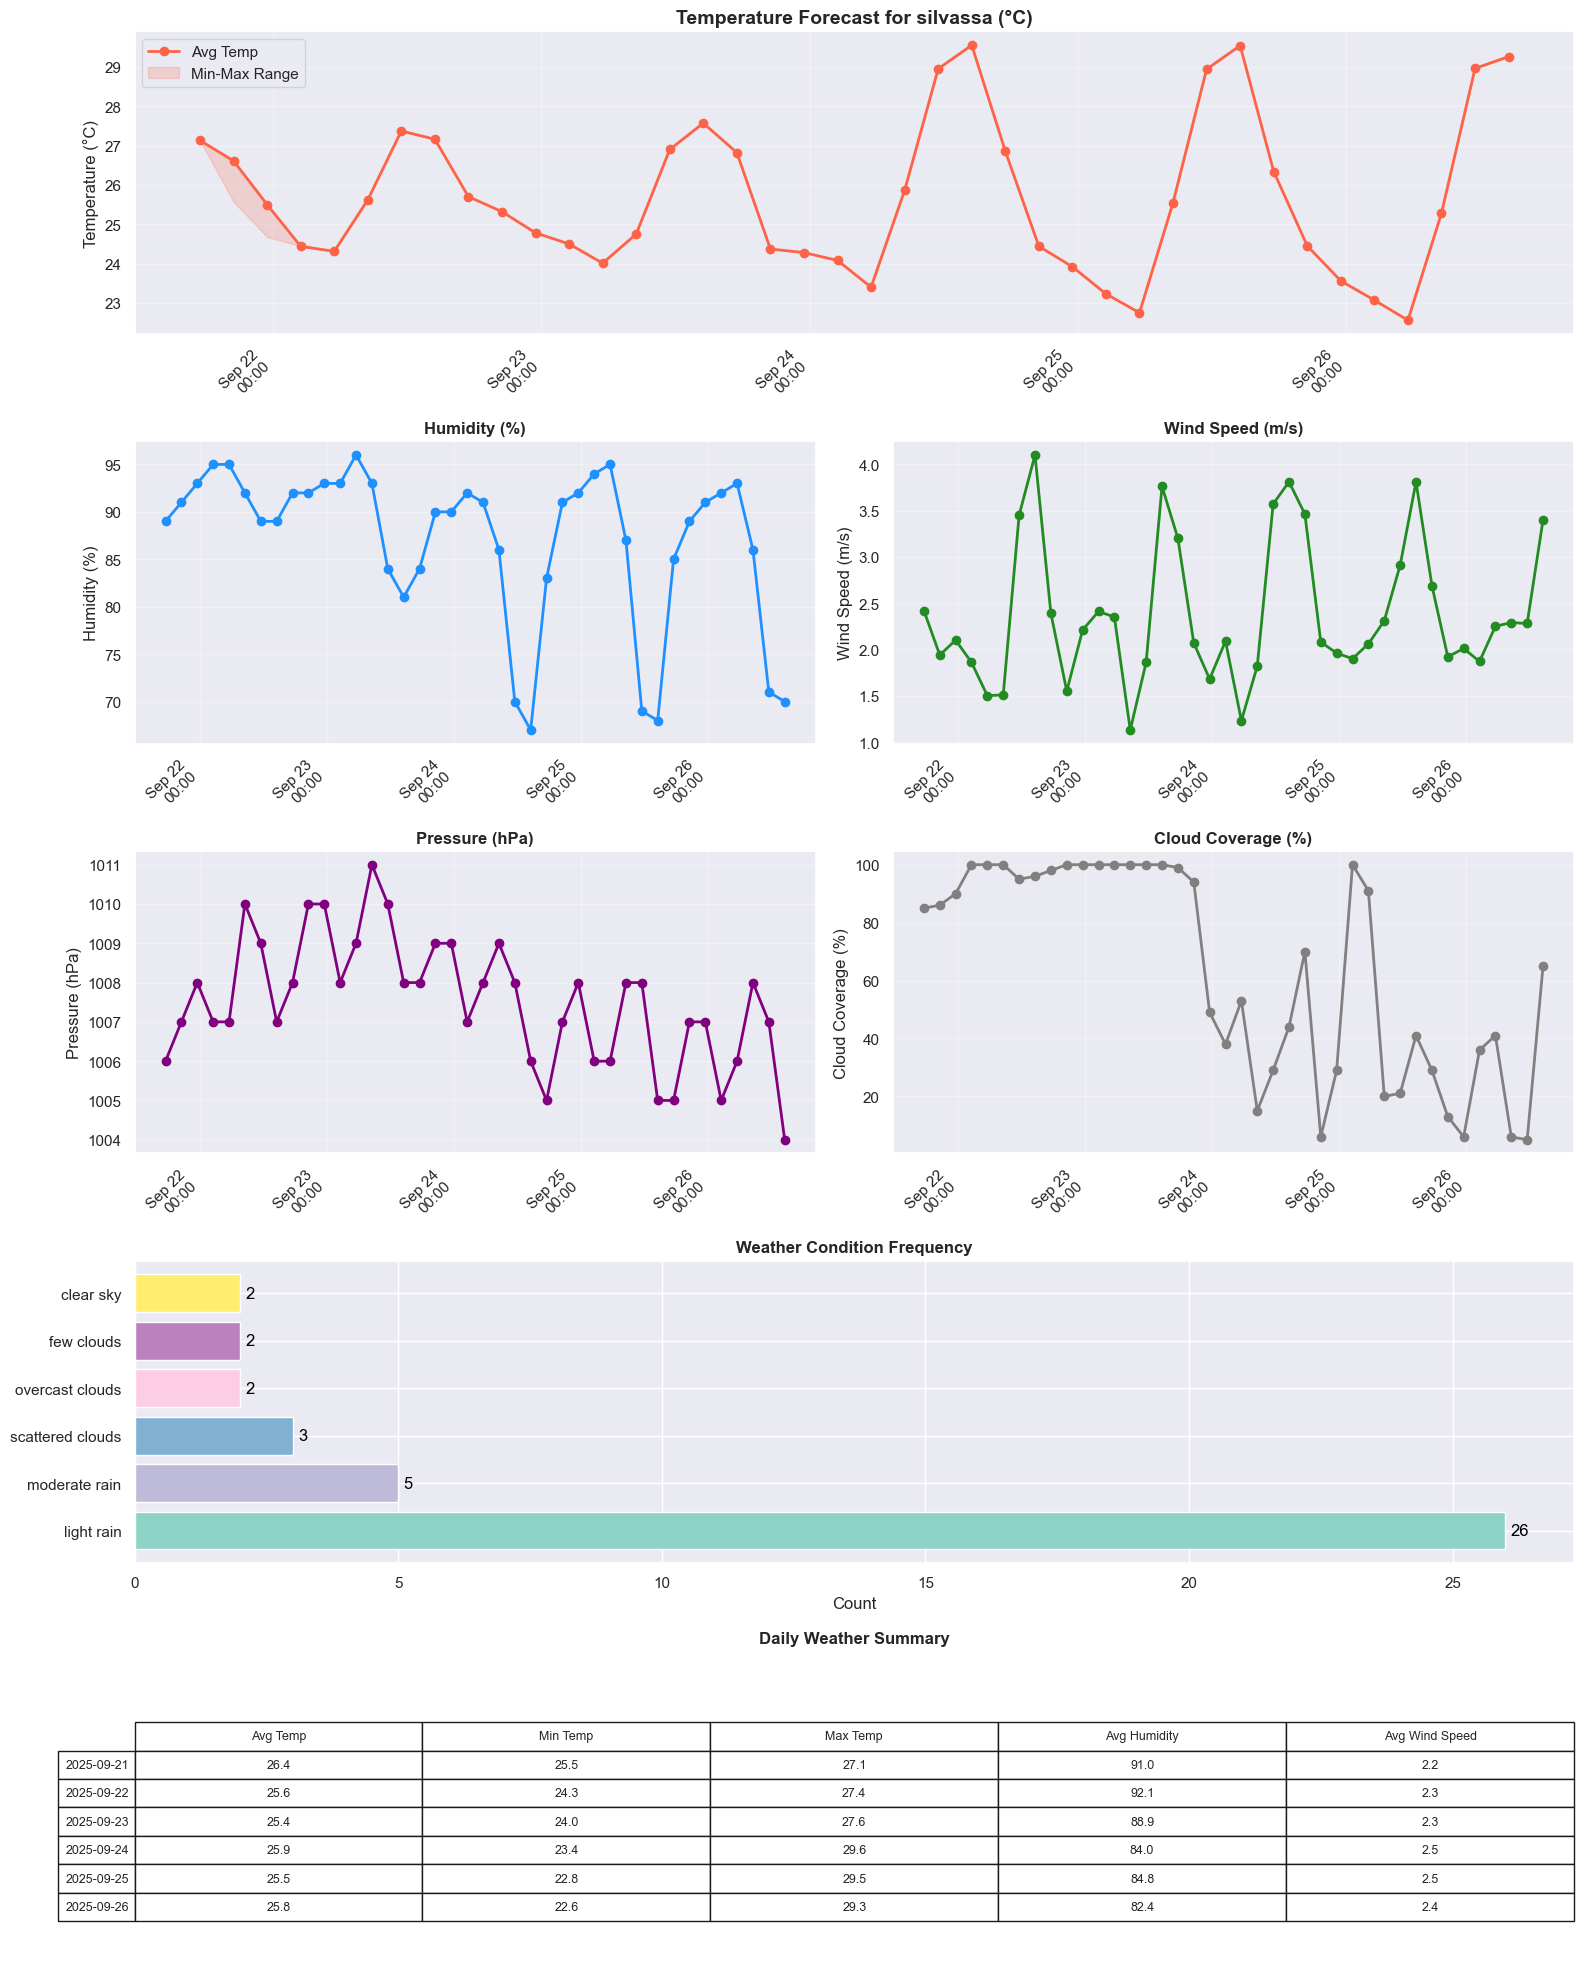

In [8]:
if data is not None and df is not None and not df.empty:
    plot_weather_data(df, city, output_dir)
else:
    print("Cannot generate dashboard without valid data.")

In [9]:
if data is not None and df is not None and not df.empty:
    print("\nWeather Forecast Summary:")
    print(f"Location: {city}")
    print(f"Forecast Period: {df['datetime'].min().strftime('%Y-%m-%d %H:%M')} to {df['datetime'].max().strftime('%Y-%m-%d %H:%M')}")
    print(f"Temperature Range: {df['temperature'].min():.1f}°C to {df['temperature'].max():.1f}°C")
    print(f"Average Temperature: {df['temperature'].mean():.1f}°C")
    print(f"Predominant Weather: {df['weather'].mode().iloc[0]}")
else:
    print("No summary statistics available.")


Weather Forecast Summary:
Location: silvassa
Forecast Period: 2025-09-21 17:30 to 2025-09-26 14:30
Temperature Range: 22.6°C to 29.6°C
Average Temperature: 25.7°C
Predominant Weather: light rain
